------------

**FPS Critic Inc., owner of PureSkill.gg, is not liable for any AWS
costs you incur. Only run this notebook if you understand and accept
the AWS billing implications.**

------------

# Getting data from the ADX

This notebook will help you download data from the main dataset off of the data exchange.

Here are some definitions around the AWS Data Exchange (ADX):
- Data Exchange: AWS service that hosts the data.
- Data Product: Listing on the ADX where we publish the csds data.
- Data Set: A container for one type of data.
- Revision: For the csds data, each revision is equivalent to one day of data. This allows granularity for both data volume and date range.

This notebook will transfer a selected set of revisions from the ADX to an S3 bucket on your AWS account. It will optionally allow you to enable automatic transfer of new revisions to S3.

# You will incur costs!

While the data set subscription as provided is free, **exporting and downloading the data set will incur a real money cost to your AWS bill according to their pricing**. Even if you are on the AWS free tier, the volume of data in this data set may exceed the free tier limits. We will summarize the expected costs, however we cannot guarantee these estimates. We recommend working with a few revisions in the data set to get real-world cost estimates for your use case.

Things that will  cost money:
- Exporting the data to S3 will generate PUT, COPY, POST, LIST requests.
- Keeping the data in S3 will incur cost for storing objects.
- If you setup auto-export of the data, you will get daily exports into your S3 bucket until you choose to disable the automatic process. This will incur increasing daily storage cost as the total data stored in your bucket will grow each day.
- Downloading data from S3 across the internet, including to your local machine, will incur data transfer charges.
- Exporting the data from the data exchange to a bucket outside of the region the data set is hosted in will incur additional data transfer charges.

For example, let's compute the cost to export a revision to a bucket in in us-east-2 and download it to our local machine. Assume this revision has size 13GB, with 350 matches, and thus 11550 objects.

- Exporting this data would incur 12k PUT requests for \$0.06.
- Since the data set is in us-east-1, and 
the bucket is in us-east-2, there is an additional data transfer cost of \$0.13. 
This would cost nothing if the bucket was also in us-east-1.
- Storing this data would cost \$0.30 per month.
- Downloading this data from S3 to you local machine would cost \$1.17.
- Thus it costs about \$1.66 to download a single revision and store it on S3 for 1 month.
https://calculator.aws/#/estimate?id=73fe611b111a0d2950d92ad2b10062b9cc01a91d

You may use [this calculator](https://calculator.aws) to estimate your costs tailored to your account and region. For full S3 pricing information, refer to [the amazon pricing page](https://aws.amazon.com/s3/pricing/)

We have included a calculator below to assist you in calculating your costs, however, we do not guarantee its accuracy. **You** are responsible for the final cost and payment of your AWS bill.

# Data Volume

The volume of data and number of files is quite large for this dataset. For example, here are the number of matches in each month for the first five months:

- December 2021: 17,952
- January 2022: 15,315
- February 2022: 9,892
- March 2022: 16,855
- April 2022: 8,717


We can use the month of April to demonstrate the volume. The 30 revisions in April in total had:

- 286,671 files
- 8,717 matches
- 275 GB

These values are used in the calculator below to estimate costs on a per-revision basis. Though, the number of matches per day is variable.  For the first batch of historical revisions, you can find [the approximate number of matches for each day](https://docs.pureskill.gg/datascience/adx/csgo/csds/revisions). There is quite a large variance in some days due to spikes in user activity. The total number of matches in a revision will not exceed 1,600, however there may be more than one revision per day to accommodate additional volume.

------------

# 0. Before you start, setup your AWS credentials

Follow the [guide on setting up AWS credentials](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html#configuration) to properly download things from the AWS Data Exchange.

# 1. Subscribe to the Dataset on the ADX

The first step to getting the data is to subscribe to the [Product](https://aws.amazon.com/marketplace/pp/prodview-v3o7zrt6okwmo) on the ADX. 

Once your subscription has been approved, you can get your dataset ID by going to the ADX, clicking on "Entitled data", going to "PureSkill.gg Competitive CS:GO Gameplay", clicking on "**pureskillgg-csgo-production-dataexchange-csds-0**" under "Entitled data sets", expanding the "Data set overview" box, and copying the "Data set ID" on the right. Paste that into the `dataset_id` variable below.

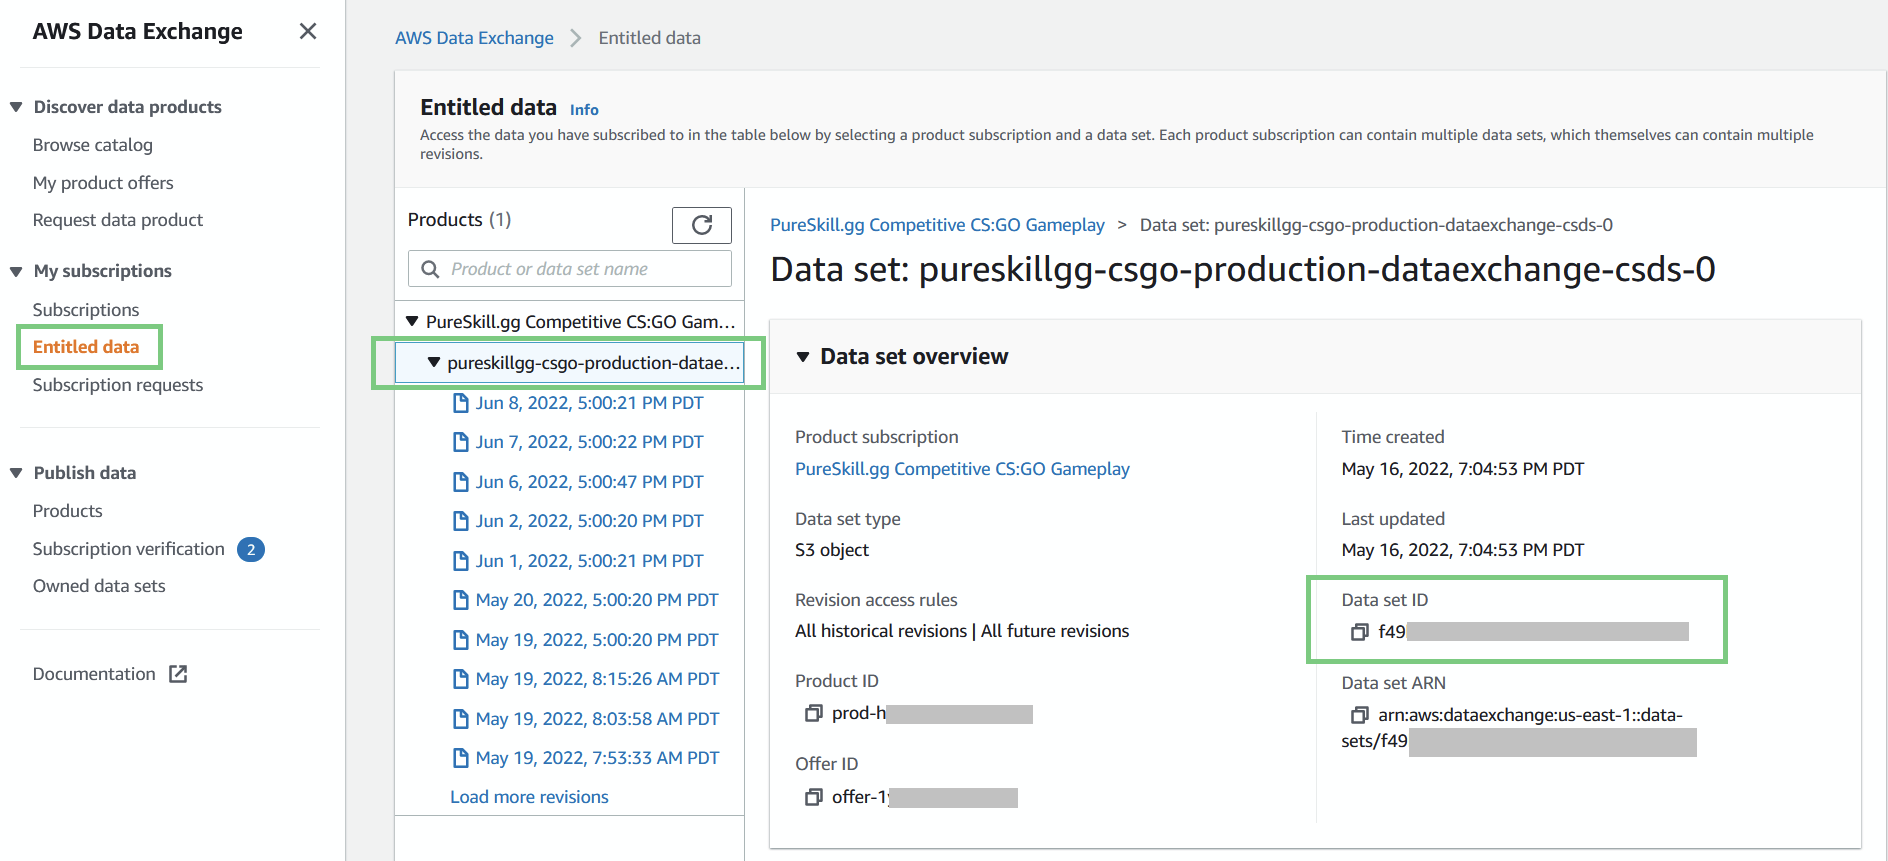

In [ ]:
dataset_id = "f49be2ef387af522a7b6f000158113e0"

In [ ]:
if dataset_id == "f49be2ef387af522a7b6f000158113e0":
    raise Exception("Your dataset_id is still the default. Please subscribe on the ADX")

# 2. Estimate Costs 

We provide the estimates below for convenience, but do not guarantee their accuracy or applicability to your AWS account. You should perform your own calculations using the cost calculator provided by AWS.

In [ ]:
start_date="2022-04-01"
end_date="2022-05-01"
days_to_keep_data_on_s3 = 30

In [ ]:
from datetime import date

revision_count = (date.fromisoformat(end_date) - date.fromisoformat(start_date)).days
print('There are',revision_count,'revisions in that date range.')

# From AWS
cost_per_get = 0.0000004 # for US East (Virginia)
cost_per_put = 0.000005 # for US East (Virginia)
cost_per_gb_per_month = 0.023 # for US East (Virginia)
cost_per_gb_transfer_from_adx = 0.00 # for US East (Virginia)
cost_per_gb_transfer_out = 0.09 # for US East (Virginia)

## Estimate for example EU region
# cost_per_get = 0.00000042 # for EU (Paris)
# cost_per_put = 0.0000053 # for EU (Paris)
# cost_per_gb_per_month = 0.024 # for EU (Paris)
# cost_per_gb_transfer_from_adx = 0.02 # for EU (Paris)
# cost_per_gb_transfer_out = 0.09 # for EU (Paris)

# # Estimate for example Asia Pacific region
# cost_per_get = 0.00000035 # for Asia Pacific (Seoul)
# cost_per_put = 0.0000045 # for Asia Pacific (Seoul)
# cost_per_gb_per_month = 0.025 # for Asia Pacific (Seoul)
# cost_per_gb_transfer_from_adx = 0.08 # for Asia Pacific (Seoul)
# cost_per_gb_transfer_out = 0.11 # for Asia Pacific (Seoul)

In [ ]:
matches_per_revision = 8717/30 # April average
# matches_per_revision = 9892/28 # Feb average
GB_per_match = 296179095022/1024/1024/1024/8717 # very precise....
files_per_match = 33

In [ ]:
days_per_month = 30

number_of_matches = number_of_revisions*matches_per_revision
number_of_files = number_of_matches*files_per_match
storage_volume_GB = number_of_matches*GB_per_match

storage_cost = storage_volume_GB*cost_per_gb_per_month*days_to_keep_data_on_s3/days_per_month

transfer_put_cost = cost_per_put*number_of_files
transfer_get_cost = cost_per_get*number_of_files

transfer_volume_cost = storage_volume_GB*cost_per_gb_transfer_from_adx

download_cost = storage_volume_GB*cost_per_gb_transfer_out

print(f"{number_of_revisions} revisions will be {round(storage_volume_GB,2)} GB, "
     f"{number_of_matches} matches, and {number_of_files} files.")
print(f"Cost to transfer to your S3 bucket: ${round(transfer_put_cost+transfer_volume_cost,3)}")
print(f"Cost to store data in S3 for {days_to_keep_data_on_s3} days: ${round(storage_cost,3)}")
print(f"Cost to transfer from S3 to local: ${round(transfer_get_cost+download_cost,3)}")
print(f"Total cost: ${round(transfer_put_cost+transfer_volume_cost+storage_cost+transfer_get_cost+download_cost,3)}")

# 3. Understand the Consqeuences of your Actions

Mark the variables true if you agree to them.

In [ ]:
i_understand_running_this_notebook_will_cost_money = False
i_understand_the_estimates_above_may_be_wrong = False
i_am_responsible_for_all_costs = False
i_have_subscribed_to_the_dataset_on_the_adx = False

In [ ]:
if (
    i_understand_running_this_notebook_will_cost_money
    and i_understand_the_estimates_above_may_be_wrong
    and i_am_responsible_for_those_costs
    and i_have_subscribed_to_the_dataset_on_the_adx
    ):
    agreed_to_terms = True
    print("Thank you for agreeing to the terms")
else:
    agreed_to_terms = False
    raise Exception("You have not accepted the terms.")

## Import the usual

In [ ]:
from pureskillgg_makenew_pyskill.notebook import setup_notebook

In [ ]:
setup_notebook()

In [ ]:
import boto3
import warnings
import json
from pureskillgg_dsdk import (
    enable_auto_exporting_adx_dataset_revisions_to_s3,
    disable_auto_exporting_adx_dataset_revisions_to_s3,
    download_adx_dataset_revision,
    get_adx_dataset_revisions,
    export_single_adx_dataset_revision_to_s3,
    export_multiple_adx_dataset_revisions_to_s3,
)

# 4. Decide what to Transfer

You must set **transfer_option** in the cell below. Here are the options and what they do:

- none: Do not transfer any data.
- range: Transfer a range of revisions from the ADX to your S3 bucket.
- latest: Transfer the latest revision from the ADX to your S3 bucket.
- all: Transfer all revisions from the ADX to your S3 bucket.
- slowly-download-to-local: Transfer a range of revisions from the ADX to your local hard drive.

To download a single revision, set the `start_date` and `end_date` to the same day.

------------

**FPS Critic Inc., owner of PureSkill.gg, is not liable for any AWS
costs your incur. Run the cells below only if you understand and accept
the AWS billing implications.**

------------

In [ ]:
# Optionally set a custom bucket name. Bucket names are universally unique. 
# Leave this set to None for the default name of [your-account-alias]-pureskillgg-dataset. 
# If you want to use an existing bucket, set its name here. 
bucket = None 

# If you would like this notebook to create the S3 bucket to receive data from the ADX. 
# If the bucket already exists, this will have no effect.
create_destination_bucket = True 

# Optionally set a prefix for all object keys exported to the bucket, e.g., some/path/. 
# We strongly recommend NOT setting this option unless you know what you are doing. 
prefix = None


# This will set a lifecycle rule on the bucket if created via this notebook.
# If the bucket already exists, no rule will be set.
# Set to None for no expiration.
days_to_keep_data_on_s3 = 30 

# Set this based on what you want to transfer. The options are in the cell above.
transfer_option = "latest"

# Set date range if you chose 'range' above
start_date="2022-04-01" # inclusive
end_date="2022-05-01" # exclusive

In [ ]:
if transfer_option == 'slowly-download-to-local':
    warnings.warn("DOWNLOADING STRAIGHT TO LOCAL WILL BE SLOW. "
                  "PERHAPS DAYS FOR A SINGLE REVISION. "
                  "It will be 100x faster or more to transfer to S3 then download from there.")

## Create bucket, if needed

In [ ]:
def will_make_bucket(client, bucket, account_id):
    try:
        client.head_bucket(
          Bucket=bucket,
          ExpectedBucketOwner=account_id
        )
    except ClientError as e:
        err = str(e)
        if '404' in err:
            return True
        if '403' in err:
            raise Exception(f"The bucket {bucket} exists and does not belong to you.")
    return False # already exists

def get_bucket_name(bucket, account_id):
    if bucket is not None:
        return bucket
    
    account_aliases = boto3.client('iam').list_account_aliases()['AccountAliases']
    if len(account_aliases) == 0:
        account_alias = account_id
    else:
        account_alias = account_aliases[0]
    return "-".join([account_alias, "pureskillgg", "dataset"])

account_id = boto3.client("sts").get_caller_identity().get("Account")
bucket = get_bucket_name(bucket, account_id)

if create_destination_bucket and agreed_to_terms:
    
    client = boto3.client('s3')
    
    
    if will_make_bucket(client, bucket, account_id):
        bucket_region = boto3.session.Session().region_name
        print(f"making bucket named {bucket} in {bucket_region}")
        
        keywords = dict(
            Bucket=bucket,
            ACL="private"
            )
        if bucket_region != 'us-east-1':
            keywords['CreateBucketConfiguration']={"LocationConstraint": bucket_region}
            
        client.create_bucket(**keywords)

        client.put_bucket_policy(
            Bucket=bucket,
            Policy=json.dumps(
                {
                    "Version": "2012-10-17",
                    "Statement": [
                        {
                            "Effect": "Allow",
                            "Principal": {"Service": "dataexchange.amazonaws.com"},
                            "Action": ["s3:PutObject", "s3:PutObjectAcl"],
                            "Resource": f"arn:aws:s3:::{bucket}/*",
                            "Condition": {"StringEquals": {"aws:SourceAccount": account_id}},
                        }
                    ],
                }
            ),
        )
        
        if days_to_keep_data_on_s3 is None:
            client.put_bucket_lifecycle_configuration(
                Bucket=bucket,
                LifecycleConfiguration={
                    "Rules": [
                        {
                            "Expiration": {
                                "Days": days_to_keep_data_on_s3,
                            },
                            "Status": "Enabled",
                            "Filter": {"Prefix": ''}
                        },
                    ],
                },
            )
        
        client.put_public_access_block(
            Bucket=bucket,
            PublicAccessBlockConfiguration={
                "BlockPublicAcls": True,
                "IgnorePublicAcls": True,
                "BlockPublicPolicy": True,
                "RestrictPublicBuckets": True,
            },
        )
    else:
        print(f"bucket {bucket} already exists.")

## Transfer latest revision from ADX to S3

In [ ]:
if transfer_option == "latest" and agreed_to_terms:
    export_single_adx_dataset_revision_to_s3(
        bucket, dataset_id, prefix=prefix
    )

## Transfer date range from ADX to S3

In [ ]:
if transfer_option == "range" and agreed_to_terms:
    export_multiple_adx_dataset_revisions_to_s3(
        bucket,
        dataset_id,
        prefix=prefix,
        start_date=start_date,
        end_date=end_date,
    )

## Transfer everything from ADX to S3

In [ ]:
if transfer_option == "all" and agreed_to_terms:
    export_multiple_adx_dataset_revisions_to_s3(
        bucket,
        dataset_id,
        prefix=prefix
    )

## Transferring single revision from ADX to local (not recommended)

This is not recommended because it will take a **VERY VERY** long time to download. Please instead download from your S3 bucket.

In [ ]:
if transfer_option == "slowly-download-to-local" and agreed_to_terms:
    ds_collection_path = os.environ.get('PURESKILLGG_TOME_DS_COLLECTION_PATH')
    download_adx_dataset_revision(ds_collection_path, dataset_id, prefix=prefix)

# 5. Transferring Data from S3 to Local

There are many many ways to do this so we won't list them all here. We generally sync one month at a time with the AWS CLI like this:

```
aws s3 sync s3://my-bucket/csds/2022/04/ /PATH/TO/ROOT/csds/2022/04
```

It is **CRITICALLY IMPORTANT** to maintain the path structure. In the example above, you could change the `/PATH/TO/ROOT` but the `csds/2022/04` is not something that you may change. The reader will not work because the folder structure is part of the key used to read each file.

# 5. Automatically Exporting New Revisions to S3

Finally, you can set a job to automatically export new revisions to your S3 bucket. Change the variables below to true to run the corresponding commands.

In [ ]:
# Enable automatic exporting of revisions to S3
enable_automatic_revision_transfer = False

# Disable automatic exporting of revisions to S3
disable_automatic_revision_transfer = False

In [ ]:
if enable_automatic_revision_transfer and disable_automatic_revision_transfer:
    raise Exception("It makes no sense to set both enable and disable revision transfer...")

## Enable exporting of revisions to S3

In [ ]:
if enable_automatic_revision_transfer and agreed_to_terms:
    disable_auto_exporting_adx_dataset_revisions_to_s3(dataset_id) # prevents duplicate jobs
    enable_auto_exporting_adx_dataset_revisions_to_s3(bucket, dataset_id, prefix=prefix)

## Disable exporting of revisions to S3

You can cancel your automatic exporting of revisions by running the code below. 

You can also disable this automatic job through the AWS console by:

1. Navigating to the ADX
1. Clicking on "Entitled data" under "My Subscriptions"
1. Click on "PureSkill.gg Competitive CS:GO Gameplay"
1. Click on the data set named "pureskillgg-csgo-production-dataexchange-csds-0"
1. Look under "Auto-export job destinations" and you should be able to Remove any outstanding jobs.

In [ ]:
if disable_automatic_revision_transfer and agreed_to_terms:
    disable_auto_exporting_adx_dataset_revisions_to_s3(dataset_id)

Advance to the [next notebook](8%20-%20Getting%20tomes%20from%20the%20ADX.ipynb).